# Gaussian Processes (For simple folk like myself)
Reference: https://distill.pub/2019/visual-exploration-gaussian-processes/ , https://medium.com/swlh/gaussian-process-regression-with-python-edd11bebdce8
           

### Main Idea
- We will focus on gaussian processes in the context of regression (note that GP's can be used for classification and even unsupervised learning).
- Here's the Wikipedia definition:

"In probability theory and statistics, a Gaussian process is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed. The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space."

- This is not a very helpful definition by any means.
- For the purpose of this notebook, a gaussian process is a probabilistic technique that allows us to estimate our confidence in a given prediction function. 

### Multivariate Gaussian Distribution
- We start with a summary of the multivariate gaussian distribution because it is the key PDF in GP's.

##### $X = [x_1,...,x_n] \sim N(\mu,\Sigma)$ 
##### - $\mu$ is the expected value of the distribution and is an $n$-dimensional vector.
##### - $\Sigma$ is the covariance matrix of the distribution and is  $n x n$ (also PSD).

### Marginalization
- When we marginalize a distribution we are simply looking at the distribution of subsets of random variables. Gaussians are chill because all marginal distributions of a gaussian are also gaussian.
##### $P_{X,Y} = [X,Y] \sim N(\mu,\Sigma) = N([\mu_x,\mu_y],\begin{pmatrix}\Sigma_{XX} & \Sigma_{XY}\\\Sigma_{YX} & \Sigma_{YY}\end{pmatrix})$

- Check this out:

##### $X \sim N(\mu_X,\Sigma_{XX})$ , $Y \sim N(\mu_Y,\Sigma_{YY})$

- Looking for the marginal distribution of one variable? No big deal:

##### $P_X(x) = \int_{y} P_{X,Y}(x,y) dy$

### Conditioning

##### $X|Y \sim N(\mu_X + \Sigma_{XY}\Sigma_{YY}^{-1}(Y-\mu_Y),\Sigma_{XX}-\Sigma_{XY}\Sigma_{YY}^{-1}\Sigma_{YX})$

- Again, not a big deal if you're looking for the marginal distribution of a single variable:

##### $P_X(x) = \int_{y} P_{X|Y}(x|y)P_{Y}(y) dy$

#### Now for the fun stuff

### Gaussian Processes

##### $X_1$ is our training data, $X_2$ is our testing data 

##### - We want to model the distribution of the testing data, $X_2$, together with the training data, $X_1$, as a multivariate gaussian.

##### - The joint distribution of $X_1$ and $X_2$, $P_{X1,X2}$, spans the space of function values we would like to predict.

##### - THIS IS SUPER IMPORTANT TO UNDERSTAND: the distribution $P_{X1,X2}$ has $|X_1| + |X_2|$ dimensions.

##### - We are interested in drawing samples from $P_{X2|X1}$
  - Making a prediction using a GP means that we draw samples from $P_{X2|X1}$
  
  
### Kernels
 
- The most difficult part of a gaussian process is determining the covariance matrix $\Sigma$.
- $\Sigma$ is generated by evaluating a kernel $k$ (covariance function) on all pairs of points. That is, the kernel is used to define the entries of the covariance matrix.
- The general form of a kernel is:

- ##### $k: \mathbb{R}^{n}x\mathbb{R}^{n} \rightarrow \mathbb{R}, \Sigma = Cov(X,X') = k(t,t')$
- The kernel controls the shape of our prediction function because it determines $\Sigma$.
- Recall, $\Sigma_{ij}$ tells us how much the ith and jth point affect each other. 

##### RBF Kernel: $\sigma^2exp(-\frac{||t-t'||^2}{2l^2})$
##### Periodic: $\sigma^2exp(-\frac{2sin^2(\pi|t-t'|/p)}{l^2})$
##### Linear: $\sigma_b^2 + \sigma^2(t-c)(t'-c)$

### Priors

- Keep the goal in mind: GP's give us a probability distribution over possible function values - each sample from the distribution is a function realization.
- Assume we don't have any training data ($\mu = 0$), so all we have is a prior distribution $P_X$.
- In this case, the prior distribution has the same dimensionality as the number of test points, i.e., $N = |X_2|$. It follows that the covariance matrix will be $NxN$.


### Posterior
- Now we have some training data, hence, we can use bayes theorem to create a posterior distribution. 
- Here are the steps:

1: Form the joint distribution $P_{X1,X2}$.

2: With conditioning, compute $P_{X2|X1}$ from $P_{X1,X2}$. This forces the set of functions to pass through the training points. 

3: Add noise to the covariance matrix to prevent the GP from overfitting the data:

##### $P_{X_2,X_1} \sim N(0,\Sigma) = N([0,0],\begin{pmatrix}\Sigma_{X_2X_2} & \Sigma_{X_2X_1}\\\Sigma_{X_1X_2} & \Sigma_{X_1X_1 + \psi^2I}\end{pmatrix}))$ 

4: By marginalizing each random variable, we can get their respective means (likely non-zero now) and standard deviations.

### Example Time

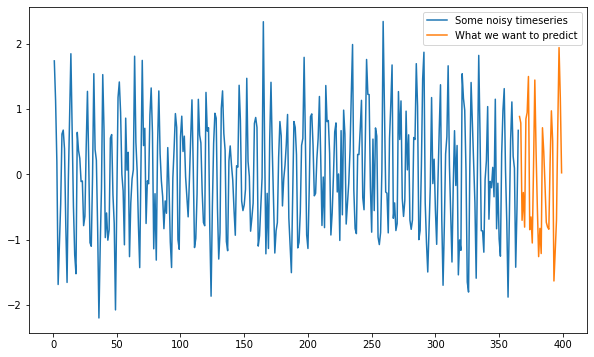

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
np.random.seed(3)
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,6))


# Create fake data
X_train = np.arange(1,366) # Inputs
y_train = np.sin(X_train) + np.random.normal(loc=0,scale=0.5,size=len(X_train))

X_test = np.arange(366,400)
y_test = np.sin(X_test) + np.random.normal(loc=0,scale=0.5,size=len(X_test))

ax.plot(X_train,y_train,label="Some noisy timeseries")
ax.plot(X_test,y_test,label="What we want to predict")
ax.legend()

In [77]:
# Pick kernel
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))

# Instantiate model
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)

# Fit model
model.fit(X_train.reshape(-1,1), y_train)

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [78]:
y_pred, std = model.predict(X_test.reshape(-1,1), return_std=True)

y_test

array([ 0.88424137,  0.78433768, -0.7054758 , -0.28044032, -0.81006001,
        0.84590478,  0.9462541 ,  1.49672851, -0.84896502, -0.65455877,
       -1.05292732,  0.12458183,  1.44263905,  0.33601718, -0.528693  ,
       -1.26176139, -0.82917333, -1.21429523,  0.7119533 ,  0.34491231,
       -0.16785084, -0.7360407 , -0.80961267, -0.84226436,  0.18218796,
        0.9708606 ,  0.50714729, -1.63465805, -1.17885373, -0.70261103,
        0.70754218,  1.93969999,  1.16525193,  0.02181403])

In [79]:
y_pred

array([3.28492585e-001, 3.52148155e-002, 8.23007276e-004, 4.25963362e-006,
       4.89525478e-009, 1.24982521e-012, 7.08999363e-017, 8.93668468e-022,
       2.50290051e-027, 1.55757105e-033, 2.15372077e-040, 6.61710774e-048,
       4.51735584e-056, 6.85232078e-065, 2.30955525e-074, 1.72964237e-084,
       2.87820392e-095, 1.06420206e-106, 8.74306920e-119, 1.59602991e-131,
       6.47374251e-145, 5.83454650e-159, 1.16841219e-173, 5.19903016e-189,
       5.14026944e-205, 1.12924121e-221, 5.51219841e-239, 5.97861038e-257,
       1.44083069e-275, 7.71547974e-295, 9.18015911e-315, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000])